# Previsão da Arrecadação da CFEM no Estado do Piauí para os anos de 2025-2030
Este projeto tem como objetivo realizar a análise exploratória, o pré-processamento e a modelagem preditiva dos dados de arrecadação do CFEM (Compensação Financeira pela Exploração de Recursos Minerais) no estado do Piauí.

## Objetivos principais:

1. **Limpeza e transformação dos dados** para garantir qualidade e consistência nas informações.
2. **Engenharia de features temporais e sazonais** para melhorar o desempenho dos modelos preditivos.
3. **Treinamento e comparação de múltiplos modelos de regressão** (Random Forest, XGBoost, Ridge e LightGBM) para identificar o melhor algoritmo para previsão da arrecadação.
4. **Validação dos modelos com métricas robustas** e visualização dos resultados para interpretação clara.
5. **Geração de previsões futuras até o ano de 2030**, permitindo apoiar decisões estratégicas relacionadas à gestão da arrecadação do CFEM.

## Principais Desafios

1. **Dados Reais**: Por serem dados reais extraídos, tratados e concatenados previamente da base de dados aberta da `ANM`, existe uma forte **não-linearidade**, o que torna a predição desafiadora e dificulta a obtenção de métricas precisas de avaliação.

2. **Alta Variância e Presença de Outliers**: A natureza dos dados apresenta alta variabilidade, refletindo períodos de picos e quedas na arrecadação, o que resulta em muitos outliers que impactam o treinamento dos modelos.

3. **Diversidade nas Alíquotas por Tipo de Mineral**: Cada tipo de mineral possui diferentes alíquotas e regras de cobrança, o que exige a codificação cuidadosa das variáveis categóricas (como `UnidadeDeMedida` e `Substância`) para que os modelos consigam indexar corretamente essas informações e capturar as especificidades de cada categoria.

4. **Qualidade e Incompletude dos Dados**: O dataset apresenta dados faltantes e registros inconsistentes, que precisam ser tratados para garantir a confiabilidade do modelo, incluindo a imputação de valores e remoção de registros inadequados.

5. **Imprevisibilidade do Pagamento e Arrecadação**: O comportamento da arrecadação do setor minerário é influenciado por fatores externos complexos, como políticas de fomento locais e internacionais, além de eventos econômicos e regulatórios, que introduzem incertezas e dificultam previsões estáveis.

6. **Não-Linearidade na Extração de Minérios**: A produção mineral não segue padrões lineares simples, sendo afetada por fatores técnicos, econômicos e ambientais, o que exige a utilização de modelos que capturem essas relações complexas e não-lineares.

> Esses desafios reforçam a necessidade de um tratamento cuidadoso dos dados, engenharia de features avançada e a aplicação de múltiplos modelos de machine learning para alcançar previsões confiáveis e úteis para o planejamento estratégico do setor.



# 1. Importação de Bibliotecas e Configurações Iniciais
---
1. **Importação de Bibliotecas Essenciais**
   - `pandas` e `numpy`: manipulação e análise de dados.
   - `matplotlib.pyplot` e `seaborn`: visualização gráfica.
   - `datetime`: manipulação avançada de datas e horas.
     

2. **Importação de Ferramentas para Machine Learning**
   - `train_test_split`: divisão dos dados em conjuntos de treino e teste.
   - `OneHotEncoder`, `ColumnTransformer`, `Pipeline`: pré-processamento e construção de pipelines para modelos.
   - Métricas para avaliação de regressão: `r2_score`, `mean_absolute_error`, `mean_squared_error`.
     

3. **Modelos de Regressão Importados**
   - `XGBRegressor`: modelo de gradient boosting eficiente.
   - `RandomForestRegressor`: ensemble baseado em árvores de decisão.
   - `Ridge`: regressão linear com regularização L2.
     

4. **Configuração para Supressão de Warnings**
   - Desabilita avisos do tipo warning para evitar poluição visual durante a execução do código.



In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore")

# 2. Carregamento e inspeção inicial dos dados

In [93]:
BASE_PATH = "/kaggle/input/cfem-arrecadacao-pi/CFEM_Arrecadacao_PI.csv"
df = pd.read_csv(BASE_PATH, encoding='latin1')

print(df.head())

    Ano  Mês  Processo  AnoDoProcesso Tipo_PF_PJ        CPF_CNPJ  \
0  2003    5  800083.0         1992.0         PJ  07258122000121   
1  2003    5       NaN            NaN         PJ  09588906000143   
2  2003    5       NaN            NaN         PJ  01604657000120   
3  2003    5       NaN            NaN         PJ  41267949000130   
4  2003    5       NaN            NaN         PJ  69628683000122   

              Substância  UF  CodigoMunicipio    Município  \
0                 ARGILA  PI          2202208  CAMPO MAIOR   
1               CASCALHO  PI          2211001     TERESINA   
2  ARGILA P/CER. VERMELH  PI          2202208  CAMPO MAIOR   
3                 SEIXOS  PI          2211001     TERESINA   
4                 ARGILA  PI          2211001     TERESINA   

  QuantidadeComercializada UnidadeDeMedida ValorRecolhido          DataCriacao  
0                     1329             t             88,5  2003-05-05 10:33:00  
1                      750             m3           72,7

# 3. Limpeza e transformação dos dados
---

1. **Cópia de Segurança do DataFrame**

   Uma cópia do DataFrame original é criada para preservar os dados brutos e evitar alterações indesejadas na estrutura original.

---

2. **Conversão de Colunas Numéricas**

   As colunas `QuantidadeComercializada` e `ValorRecolhido` têm seus valores numéricos convertidos do formato textual (com vírgulas) para `float64`. Isso permite o tratamento adequado dessas variáveis em análises e modelagens futuras.

---

3. **Criação da Coluna `Mes/Ano`**

   É criada uma nova coluna de data no formato `"MM-YYYY"`, a partir das colunas `Mês` e `Ano`. Esta coluna será útil para agrupamentos e ordenações temporais.

---

4. **Padronização de Categorias**

   Os valores das colunas `UnidadeDeMedida` e `Substância` são transformados para string e têm espaços em branco removidos. Essa etapa evita inconsistências nos agrupamentos por categorias.

---

5. **Conversão da Coluna `DataCriacao`**

   A coluna `DataCriacao` é convertida para o formato `datetime`, utilizando `errors='coerce'` para garantir que entradas inválidas sejam tratadas como `NaT` (valores ausentes).

---

6. **Remoção de Valores Ausentes**

   Registros com valores nulos nas colunas `ValorRecolhido` ou `QuantidadeComercializada` são removidos. O número de registros removidos é exibido via `print` para controle de qualidade dos dados.

---

7. **Tratamento de Zeros na `QuantidadeComercializada`**

   - Os valores 0 são considerados inválidos e substituídos por `NaN`.
   - Em seguida, os valores ausentes são preenchidos com a **mediana da `QuantidadeComercializada`** agrupada por `Substância` e `UnidadeDeMedida`.
   - Essa abordagem preserva a distribuição dos dados e evita distorções causadas por imputações arbitrárias.

---

8. **Ordenação Cronológica**

   O DataFrame é ordenado pela coluna `DataCriacao` e os índices são resetados. Isso é fundamental para a criação futura de variáveis de defasagem (lags) e médias móveis.




In [94]:
def limpar_transformar_dados(df):

    df_limpo = df.copy()

    # Transformar para o formato float64 após a substituição de "," por "."
    df_limpo[['QuantidadeComercializada', 'ValorRecolhido']] = df_limpo[['QuantidadeComercializada', 'ValorRecolhido']].replace(',','.', regex=True).astype('float64')

    # Criar string de data no formato MM-YYYY
    df_limpo['Mes/Ano'] = df_limpo['Mês'].astype(str).str.zfill(2) + '-' + df_limpo['Ano'].astype(str)

    # Padronizar nomes de colunas e valores categóricos
    df_limpo['UnidadeDeMedida'] = df_limpo['UnidadeDeMedida'].astype(str).str.strip()
    df_limpo['Substância'] = df_limpo['Substância'].astype(str).str.strip()
    
    # Converter a coluna 'DataCriacao' para datetime
    df_limpo['DataCriacao'] = pd.to_datetime(df_limpo['DataCriacao'], errors='coerce')
    
    # Remover linhas com valores ausentes nas colunas numéricas
    registros_inicial = len(df_limpo)
    df_limpo = df_limpo.dropna(subset=['ValorRecolhido', 'QuantidadeComercializada'])
    registros_final = len(df_limpo)

    # Log para verificação dos registros removidos
    print(f"\nRegistros removidos por valores ausentes: {registros_inicial - registros_final}")

    # Replace de 0 por NAN na coluna 'QuantidadeComercializada' e substituindo pela mediana do valor agrupado pela Substância e Unidade de Medida daquele dado
    # Obs:. A presença de 0 nessa variável afeta o treinamento dos modelos, visto que um valor nulo para uma declaração de CFEM não faz sentido
    # Obs2:. Preencher com a mediana dos valores agrupados por Unidade e Substância busca aproximar uma melhor proximidade e precisão no fillna daquele dado
    df_limpo['QuantidadeComercializada'] = df_limpo['QuantidadeComercializada'].replace(0, np.nan)
    df_limpo['QuantidadeComercializada'] = df_limpo.groupby(
        ['Substância', 'UnidadeDeMedida']
    )['QuantidadeComercializada'].transform(lambda x: x.fillna(x.median()))

    # Ordenar o DataFrame por data - Visando o Data Engineering de variáveis de Lag 
    df_limpo = df_limpo.sort_values('DataCriacao').reset_index(drop=True)

    print("\nLimpeza e transformação concluídas.")

    return df_limpo

df_limpo = limpar_transformar_dados(df)
print(f"\n Dataframe tratado: {df_limpo.head()}")


Registros removidos por valores ausentes: 109

Limpeza e transformação concluídas.

 Dataframe tratado:     Ano  Mês  Processo  AnoDoProcesso Tipo_PF_PJ        CPF_CNPJ  \
0  2003    5  811539.0         1976.0         PJ  27184936000176   
1  2003    5       NaN            NaN         PJ  09588906000143   
2  2003    5       NaN            NaN         PJ  07196033002222   
3  2003    5  800083.0         1992.0         PJ  07258122000121   
4  2003    5       NaN            NaN         PJ  01604657000120   

              Substância  UF  CodigoMunicipio    Município  \
0               CALCÁRIO  PI          2204303   FRONTEIRAS   
1               CASCALHO  PI          2211001     TERESINA   
2           ÁGUA MINERAL  PI          2211001     TERESINA   
3                 ARGILA  PI          2202208  CAMPO MAIOR   
4  ARGILA P/CER. VERMELH  PI          2202208  CAMPO MAIOR   

   QuantidadeComercializada UnidadeDeMedida  ValorRecolhido  \
0                   35969.0               t       

# 4. Análise Exploratória pós Limpeza e Transformação dos dados
---

1. **Informações Gerais**

Exibe dados básicos sobre o DataFrame `df_limpo`:
- Dimensões do dataset (`shape`)
- Lista de colunas disponíveis
- As primeiras linhas com `head()` para inspecionar o conteúdo

---

2. **Validação dos Dados Limpos**

Confirma se a limpeza foi realizada corretamente:
- Número total de registros
- Soma total do valor recolhido (`ValorRecolhido`)

---

3. **Análise por Unidade de Medida**

Para cada **Unidade de Medida**:
- Quantidade de registros
- Valor total recolhido
- Quantidade total comercializada

Também é gerada uma tabela com a **soma total de valores arrecadados por Unidade de Medida**, ordenada de forma decrescente.

---

4. **Visualizações Gráficas**

Dois gráficos são criados lado a lado para análise mais visual:

- **Gráfico de Barras** (`barplot`) com o valor total arrecadado por Unidade de Medida
- **Boxplot com escala logarítmica** para analisar a **distribuição dos valores recolhidos**, identificando **dispersão**, **outliers** e **assimetria** por unidade

As Unidades de Medida são ordenadas com base na mediana dos valores arrecadados.

---

5. Verificação de Registros Duplicados
Verifica se existem **linhas duplicadas** no DataFrame. Embora duplicações possam ser esperadas em datasets temporais, esta etapa permite quantificá-las para análise posterior.


=== INFORMAÇÕES GERAIS DO DATASET ===

Shape: (23693, 15)

Colunas: ['Ano', 'Mês', 'Processo', 'AnoDoProcesso', 'Tipo_PF_PJ', 'CPF_CNPJ', 'Substância', 'UF', 'CodigoMunicipio', 'Município', 'QuantidadeComercializada', 'UnidadeDeMedida', 'ValorRecolhido', 'DataCriacao', 'Mes/Ano']

Primeiras linhas:
    Ano  Mês  Processo  AnoDoProcesso Tipo_PF_PJ        CPF_CNPJ  \
0  2003    5  811539.0         1976.0         PJ  27184936000176   
1  2003    5       NaN            NaN         PJ  09588906000143   
2  2003    5       NaN            NaN         PJ  07196033002222   
3  2003    5  800083.0         1992.0         PJ  07258122000121   
4  2003    5       NaN            NaN         PJ  01604657000120   

              Substância  UF  CodigoMunicipio    Município  \
0               CALCÁRIO  PI          2204303   FRONTEIRAS   
1               CASCALHO  PI          2211001     TERESINA   
2           ÁGUA MINERAL  PI          2211001     TERESINA   
3                 ARGILA  PI          22022

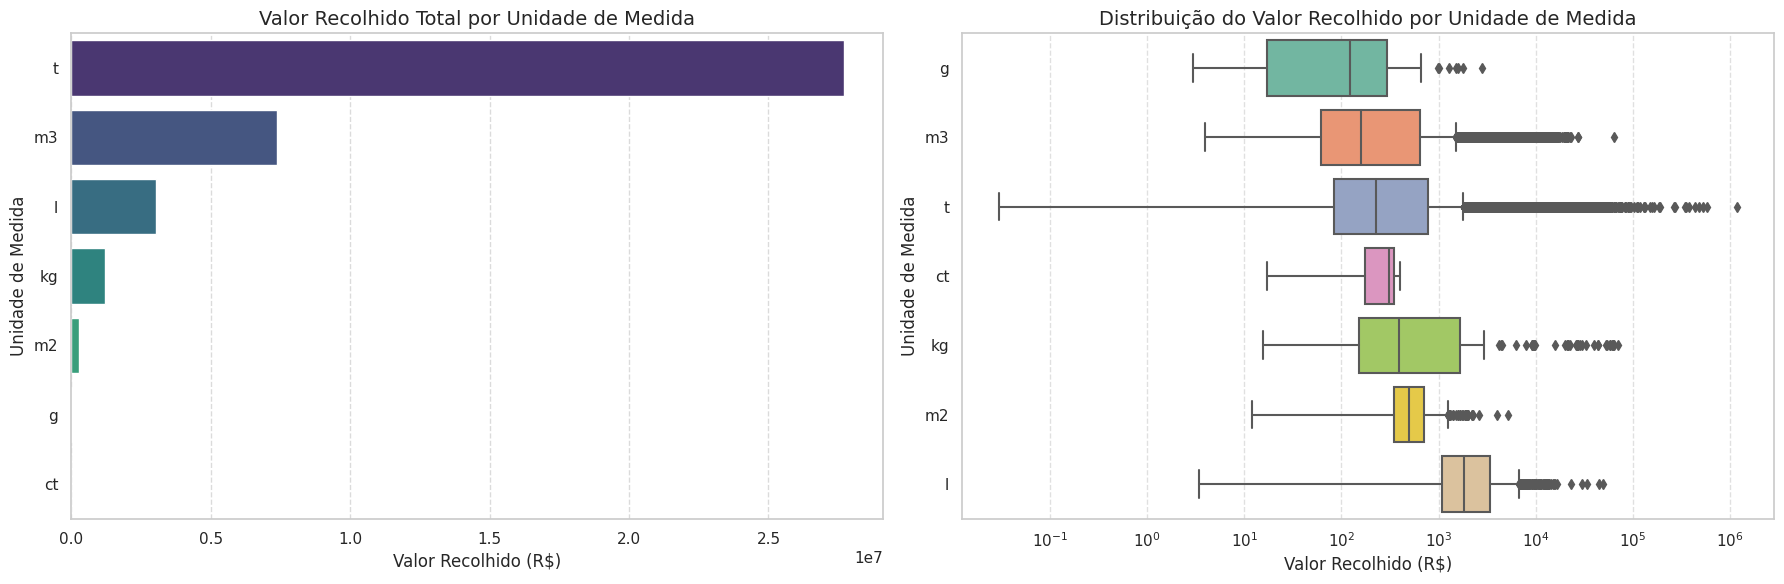


Registros duplicados: 99

Valores recolhidos negativos: 0

Quantidades comercializadas negativas: 0


In [95]:

print("=== INFORMAÇÕES GERAIS DO DATASET ===")
print(f"\nShape: {df_limpo.shape}")
print(f"\nColunas: {list(df_limpo.columns)}")
print(f"\nPrimeiras linhas:")
print(df_limpo.head())

print("\n=== VALIDAÇÃO DOS DADOS LIMPOS ===")
print(f"\nRegistros: {len(df_limpo):,}")
print(f"Valor total recolhido: R$ {df_limpo['ValorRecolhido'].sum()}")

unidades = df_limpo['UnidadeDeMedida'].unique().copy()
print("\n=== POR UNIDADES DE MEDIDA ===")
for unidade in unidades:
    print(f"\n{unidade} - Registros: {len(df_limpo[df_limpo['UnidadeDeMedida'] == unidade]):,}\nValor total: R$ {df_limpo[df_limpo['UnidadeDeMedida'] == unidade]['ValorRecolhido'].sum():,.2f}\nQuantidade Comercializada total:{df_limpo[df_limpo['UnidadeDeMedida'] == unidade]['QuantidadeComercializada'].sum():,.2f}")

soma_por_unidade = df_limpo.groupby('UnidadeDeMedida')['ValorRecolhido'].sum().sort_values(ascending=False).reset_index()

# Barplot e Boxplot dos valores arrecadados por Unidade de Medida
sns.set(style="whitegrid")
df_box = df_limpo[df_limpo['ValorRecolhido'] > 0].copy()
medianas = df_box.groupby('UnidadeDeMedida')['ValorRecolhido'].median().sort_values()
ordem = medianas.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha, 2 colunas

sns.barplot(x='ValorRecolhido', y='UnidadeDeMedida', data=soma_por_unidade, palette='viridis', ax=axes[0])
axes[0].set_title('Valor Recolhido Total por Unidade de Medida', fontsize=14)
axes[0].set_xlabel('Valor Recolhido (R$)', fontsize=12)
axes[0].set_ylabel('Unidade de Medida', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

sns.boxplot(data=df_box, x='ValorRecolhido', y='UnidadeDeMedida', order=ordem, palette='Set2', showfliers=True, ax=axes[1])
axes[1].set_title('Distribuição do Valor Recolhido por Unidade de Medida', fontsize=14)
axes[1].set_xlabel('Valor Recolhido (R$)', fontsize=12)
axes[1].set_ylabel('Unidade de Medida', fontsize=12)
axes[1].set_xscale('log')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# As duplicatas são esperadas devido à natureza do dataset, mas vamos verificar se há registros duplicados
dup = df_limpo.duplicated()
duplicatas = df_limpo[dup]

# Mostrar duplicadas
print(f"\nRegistros duplicados: {len(duplicatas)}")

# Verificar valores negativos
valores_negativos = (df_limpo['ValorRecolhido'] < 0).sum()
qtd_negativos = (df_limpo['QuantidadeComercializada'] < 0).sum()
print(f"\nValores recolhidos negativos: {valores_negativos}")
print(f"\nQuantidades comercializadas negativas: {qtd_negativos}")

# 5. Agrupamento e visualização da arrecadação anual


---

1. Função `agrupar_df(df)`

Esta função realiza o **agrupamento e agregação** dos dados por:
- `Mes/Ano`
- `UnidadeDeMedida`
- `Substância`

A agregação executa as seguintes operações:
- **`ValorRecolhido`**: soma dos valores por grupo.
- **`QuantidadeComercializada`**: soma das quantidades.
- **`Ano`**: valor mínimo do ano (usado como referência temporal).

Após a agregação, o índice é redefinido com `reset_index()` para manter a estrutura de DataFrame convencional.

> Importante notar o crescimento acelerado da arrecadação nos últimos anos, fator que torna importante um bom `Feature Engineering` e configuração iterativa dos dados de predição


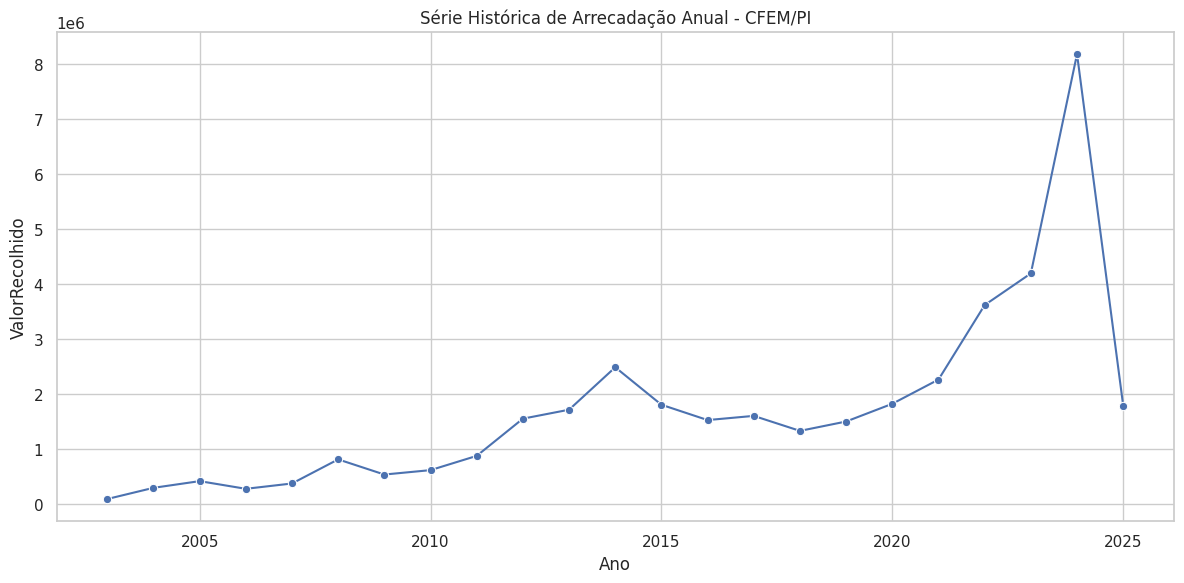

In [96]:
def agrupar_df(df):
    df = df.groupby(['Mes/Ano', 'UnidadeDeMedida', 'Substância']).agg({
        'ValorRecolhido': 'sum',
        'QuantidadeComercializada': 'sum',
        'Ano': 'min'
    }).reset_index()
    return df

df_agrupado = agrupar_df(df_limpo)

# Visualização
plt.figure(figsize=(12,6))
df_total_ano = df_agrupado.groupby('Ano')['ValorRecolhido'].sum().reset_index()
sns.lineplot(data=df_total_ano, x='Ano', y='ValorRecolhido', marker='o')
plt.title('Série Histórica de Arrecadação Anual - CFEM/PI')
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Feature Engineering
---
###  Função `feature_engineering(df)`

Esta função aplica **engenharia de atributos** (features) sobre um DataFrame contendo dados temporais relacionados à arrecadação do CFEM, estruturando o conjunto de dados para uso em modelos preditivos.

---

1. **Conversão e Ordenação Temporal**
- Converte a coluna `Mes/Ano` para o tipo `datetime` com formato `%m-%Y`.
- Ordena o DataFrame cronologicamente com base nessa coluna.

---

2. **Extração de Componentes Temporais**
- Cria duas colunas auxiliares:
  - `mes`: número do mês (1 a 12).
  - `trimestre`: número do trimestre (1 a 4), útil para capturar sazonalidade trimestral.

---

3. **Criação de Features de Defasagem (*Lags*)**
Aplica `groupby` por `UnidadeDeMedida` e `Substância`, e cria variáveis com os valores dos meses anteriores:
- Para `QuantidadeComercializada`:
  - `lag_qtd_1`: 1 mês de defasagem.
  - `lag_qtd_2`: 2 meses de defasagem.
- Para `ValorRecolhido`:
  - `lag_valor_1` e `lag_valor_2` (mesma lógica).

---

4. **Médias Móveis**
Cria janelas móveis com defasagem (shift) para evitar vazamento de dados futuros:
- Para `QuantidadeComercializada`:
  - `rolling_qtd_3m`: média dos últimos 3 meses.
  - `rolling_qtd_6m`: média dos últimos 6 meses.
- Para `ValorRecolhido`: mesmo padrão com `rolling_valor_3m` e `rolling_valor_6m`.

---

5. **Transformações Cíclicas**
Incorpora a **sazonalidade** com transformações trigonométricas:
- Mês:
  - `mes_sin`, `mes_cos`: codificação cíclica (12 meses).
- Trimestre:
  - `trim_sin`, `trim_cos`: codificação cíclica (4 trimestres).

Essa abordagem ajuda os modelos a aprenderem padrões que se repetem ao longo do tempo (ex: aumento recorrente em determinados meses).

---

6. **Limpeza de Valores Nulos**
Remove linhas com `NaN` gerados pelas operações de `shift()` e `rolling()`, garantindo consistência nos dados de entrada do modelo.

---

>  A função retorna um DataFrame com variáveis temporais, defasadas, médias móveis e transformações sazonais — todos essenciais para melhorar a capacidade preditiva dos modelos de regressão aplicados ao CFEM.


In [97]:
def feature_engineering(df):
    df['Mes/Ano'] = pd.to_datetime(df['Mes/Ano'], format = '%m-%Y')
    df = df.sort_values('Mes/Ano').copy()

    # Variáveis temporais
    df['mes'] = df['Mes/Ano'].dt.month
    df['trimestre'] = df['Mes/Ano'].dt.quarter

    # Lags - QuantidadeComercializada
    df['lag_qtd_1'] = df.groupby(['UnidadeDeMedida', 'Substância'])['QuantidadeComercializada'].shift(1)
    df['lag_qtd_2'] = df.groupby(['UnidadeDeMedida', 'Substância'])['QuantidadeComercializada'].shift(2)

    # Lags - ValorRecolhido
    df['lag_valor_1'] = df.groupby(['UnidadeDeMedida', 'Substância'])['ValorRecolhido'].shift(1)
    df['lag_valor_2'] = df.groupby(['UnidadeDeMedida', 'Substância'])['ValorRecolhido'].shift(2)

    # Médias móveis de 3 e 6 meses
    df['rolling_qtd_3m'] = df.groupby(['UnidadeDeMedida', 'Substância'])['QuantidadeComercializada'].transform(lambda x: x.shift(1).rolling(window=3).mean())
    df['rolling_qtd_6m'] = df.groupby(['UnidadeDeMedida', 'Substância'])['QuantidadeComercializada'].transform(lambda x: x.shift(1).rolling(window=6).mean())

    df['rolling_valor_3m'] = df.groupby(['UnidadeDeMedida', 'Substância'])['ValorRecolhido'].transform(lambda x: x.shift(1).rolling(window=3).mean())
    df['rolling_valor_6m'] = df.groupby(['UnidadeDeMedida', 'Substância'])['ValorRecolhido'].transform(lambda x: x.shift(1).rolling(window=6).mean())

    # Transformação cíclica, com foco em capturar a sazonalidade de arrecadação do CFEM - O mesmo apresenta picos e depressões em meses específicos do ano
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    df['trim_sin'] = np.sin(2 * np.pi * df['trimestre'] / 4)
    df['trim_cos'] = np.cos(2 * np.pi * df['trimestre'] / 4)

    # Remover linhas com valores nulos resultantes dos lags e médias móveis devido ao shift
    df = df.dropna(subset=['lag_qtd_1', 'lag_qtd_2', 'lag_valor_1', 'lag_valor_2','rolling_qtd_3m', 'rolling_qtd_6m','rolling_valor_3m', 'rolling_valor_6m'])
    return df

# 7. Treinamento dos Modelos 
---
### Treinamento e Avaliação de Modelos de Regressão

Esta célula realiza o pipeline completo de preparação de dados, modelagem e avaliação de três algoritmos de regressão para prever a variável-alvo `ValorRecolhido`.

#### Etapas principais:

1. **Pré-processamento dos Dados**
   - Aplicação de funções personalizadas para limpeza (`limpar_transformar_dados`), agregação (`agrupar_df`) e criação de variáveis (`feature_engineering`).
   - Definição da variável-alvo `target` e das features numéricas e categóricas.

2. **Modelos Utilizados**
   - `RandomForestRegressor`: modelo ensemble baseado em árvores de decisão.
   - `XGBRegressor`: algoritmo de boosting otimizado.
   - `Ridge`: regressão linear com regularização L2.

3. **Divisão dos Dados**
   - Separação dos dados em treino e teste (80/20) com `train_test_split`.

4. **Pipeline de Pré-processamento**
   - Utilização de `ColumnTransformer` com:
     - `passthrough` para variáveis numéricas.
     - `OneHotEncoder` (com `drop='first'`) para variáveis categóricas, prevenindo multicolinearidade.

5. **Treinamento dos Modelos**
   - Cada modelo é encapsulado em um `Pipeline` e treinado com os dados de treino.

6. **Predição e Avaliação**
   - Realiza-se a predição com os dados de teste.
   - Cálculo de métricas de desempenho:
     - R² (coeficiente de determinação)
     - MAE (erro absoluto médio)
     - MSE (erro quadrático médio)
     - RMSE (raiz do erro quadrático médio)

7. **Saída dos Resultados**
   - Impressão das métricas para cada modelo, permitindo comparação objetiva do desempenho.


In [98]:

df_limpo = limpar_transformar_dados(df)
df_agrupado = agrupar_df(df_limpo)
df_fe = feature_engineering(df_agrupado)

#%%
# Definir target e features
target = ['ValorRecolhido']
y = df_fe[target]

features_num = [
    'lag_qtd_1', 'lag_qtd_2', 'lag_valor_1', 'lag_valor_2',
    'rolling_qtd_3m', 'rolling_qtd_6m', 'rolling_valor_3m', 'rolling_valor_6m',
    'mes_sin', 'mes_cos', 'trim_sin', 'trim_cos'
]
features_cat = ['UnidadeDeMedida', 'Substância']

X = df_fe[features_num + features_cat]

# Definindo os Modelos e seleção de parâmetros a serem treinados

model_rfr = RandomForestRegressor(n_estimators=500,
                                  max_depth= 5,
                                  min_samples_leaf=5,) 

model_xgb = XGBRegressor(use_label_encoder=False, eval_metric='rmse')

model_ridge = Ridge(alpha=1.0,fit_intercept=True)

# Dividir dados em treino e teste - visando utilizar de métricas de avaliação de modelos de Regressão para decidir qual modelo utilizar na predição
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# OneHotEncoder para as variáveis categóricas - Unidade de Medida e Substancia
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', features_num),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features_cat)
    ]
)

# Pipelines de pré-processamento e treinamento dos modelos
pipe_rfr = Pipeline([
    ('preprocessamento', preprocessor),
    ('model', model_rfr)
])

pipe_xgb = Pipeline([
    ('preprocessamento', preprocessor),
    ('model', model_xgb)
])

pipe_ridge = Pipeline([
    ('preprocessamento', preprocessor),
    ('model', model_ridge)
])


# Fitting dos modelos
pipe_rfr.fit(X_train, y_train.values.ravel())
pipe_xgb.fit(X_train, y_train.values.ravel())
pipe_ridge.fit(X_train, y_train.values.ravel())


# Predição em cima dos dados de Teste divididos anteriormente, com foco na avaliação das métricas para cada modelo
y_pred_rfr = pipe_rfr.predict(X_test)
y_pred_xgb = pipe_xgb.predict(X_test)
y_pred_ridge = pipe_ridge.predict(X_test)

# Função para calcular métricas para os modelos
def calcular_metricas(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

metricas_rfr = calcular_metricas(y_test, y_pred_rfr)
metricas_xgb = calcular_metricas(y_test, y_pred_xgb)
metricas_ridge = calcular_metricas(y_test, y_pred_ridge)

print("\n\nRandom Forest Regressor:")
for k,v in metricas_rfr.items():
    print(f"{k}: {v:.4f}")

print("\nXGBoost Regressor:")
for k,v in metricas_xgb.items():
    print(f"{k}: {v:.4f}")

print("\nRidge:")
for k,v in metricas_ridge.items():
    print(f"{k}: {v:.4f}")


Registros removidos por valores ausentes: 109

Limpeza e transformação concluídas.


Random Forest Regressor:
R2: 0.6140
MAE: 6400.4655
MSE: 550542789.8628
RMSE: 23463.6483

XGBoost Regressor:
R2: 0.6663
MAE: 6612.9183
MSE: 475999572.4707
RMSE: 21817.4144

Ridge:
R2: 0.3664
MAE: 9501.2420
MSE: 903667334.1653
RMSE: 30061.0601


# 8. Predições do CFEM para 2030
---
#### Modelo escolhido - XGBoost
1. **Geração das Datas Futuras**

A função `criar_datas_futuras()` gera uma sequência mensal de datas entre o mês seguinte ao último mês disponível no dataset até dezembro de 2030. Essas datas servirão como base para as previsões futuras do CFEM.

---

2. **Preparação da Tabela Base para Previsão**

A função `preparar_base_previsao()` cria uma base combinando todas as datas futuras com as combinações únicas de Unidade de Medida e Substância presentes no histórico, adicionando também colunas auxiliares como ano, mês e trimestre.

---

3. **Engenharia de Features Sazonais**

A função `calcular_features_sazonais()` insere componentes sazonais com funções trigonométricas (`sin` e `cos`) tanto para mês quanto para trimestre, permitindo ao modelo capturar padrões recorrentes ao longo do tempo.

---

4. **Extração de Features Históricas por Combinação**

A função `pegar_ultimos_valores()` extrai os últimos valores de `ValorRecolhido` e, se disponível, `QuantidadeRecolhida` para cada combinação de Unidade e Substância. As features incluem:
- Lags: valores dos últimos 1 e 2 meses
- Médias móveis: 3 e 6 meses

---

5. **Preenchimento das Features Históricas**

A função `preencher_features_historicas()` preenche as features lag e rolling com os valores históricos obtidos. Se os dados estiverem incompletos, médias históricas são utilizadas como fallback.

---

6. **Função de Previsão Iterativa**

A função principal `previsao_2030()` realiza a previsão mês a mês, atualizando a base com os resultados anteriores (estratégia autoregressiva). Em cada iteração:
- Os dados históricos são atualizados
- As features são preenchidas
- A previsão é gerada com o modelo XGBoost
- Em caso de erro, uma média histórica é usada

A previsão cobre todas as combinações de substância e unidade até o ano de 2030.

---

7. **Visualização dos Resultados**

A função `plotar_graficos_previsao()` gera dois gráficos principais:
- **Gráfico de barras anuais**: mostra os valores arrecadados por ano, destacando 2025 como soma de valores históricos e previstos.
- **Gráfico de linha mensal**: mostra a evolução do valor recolhido ao longo do tempo, diferenciando entre dados históricos (laranja) e previstos (azul).

---

8. **Métricas do Modelo**

A função `plotar_metricas_modelo()` imprime as métricas de avaliação (R², MAE, RMSE) para cada modelo treinado.

---

9. **Comparação entre Modelos**

A função `plotar_comparacao_modelos()` compara o desempenho dos modelos Random Forest, XGBoost e Ridge por meio de gráficos de barras para:
- R² (quanto mais alto, melhor)
- MAE e RMSE (quanto menores, melhor)

---

10. **Execução das Previsões**

As previsões são executadas com:
```python
previsoes_2030 = previsao_2030(df_fe, pipe_xgb, features_num, features_cat)


 Processando 65 meses...
Processando 2025...
Processando 2026...
Processando 2027...
Processando 2028...
Processando 2029...
Processando 2030...
 Previsões iterativas concluídas!


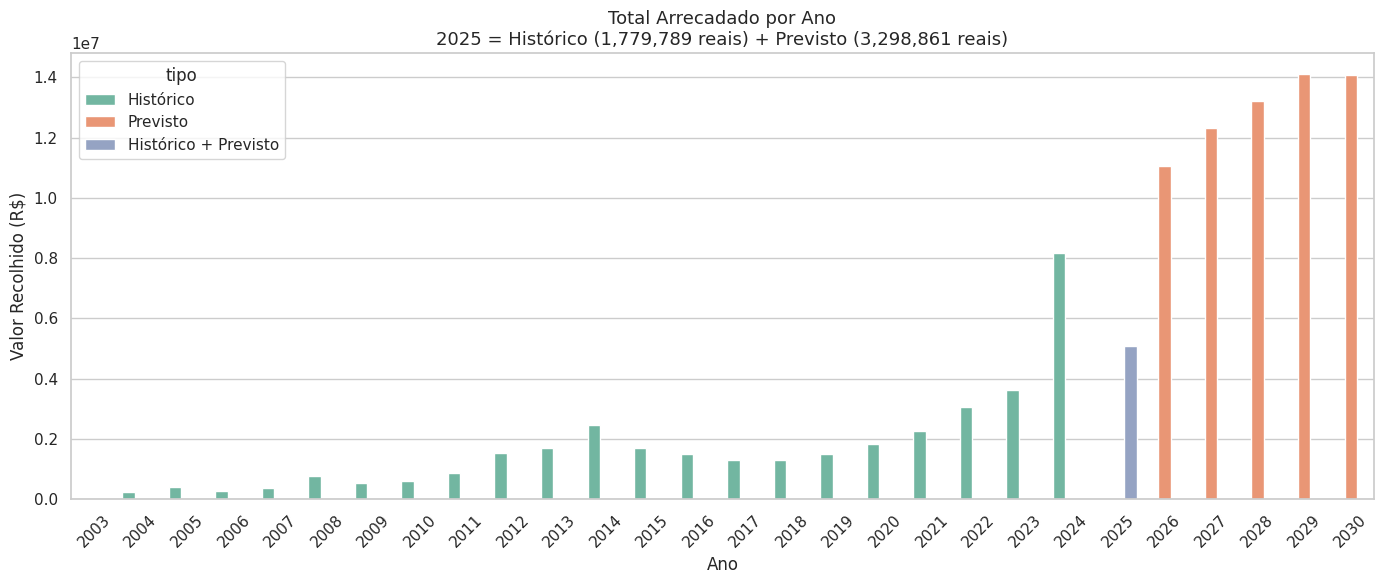

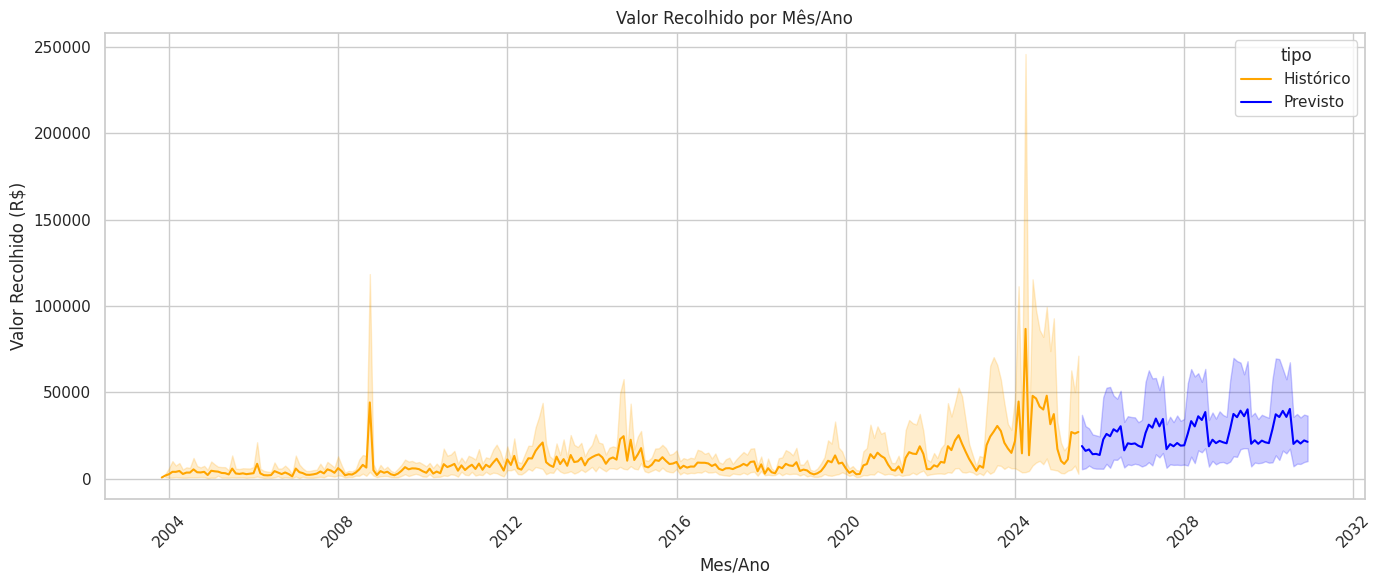

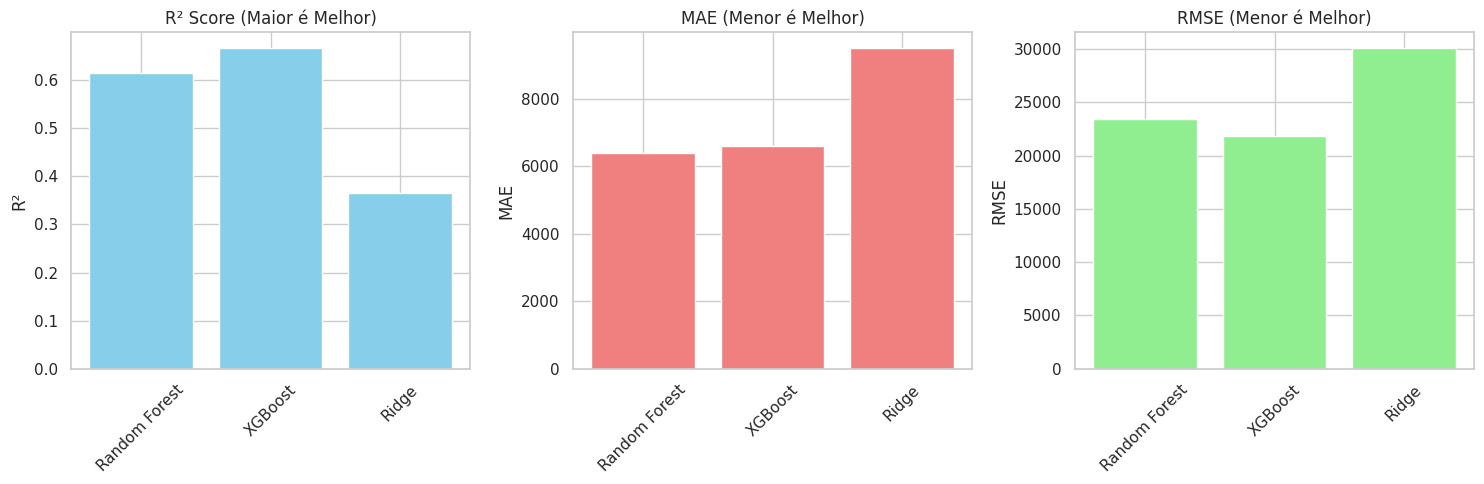

In [99]:
def criar_datas_futuras(df_fe):
    ultimo_mes = df_fe['Mes/Ano'].max()
    proximas_datas = pd.date_range(
        start=ultimo_mes + pd.offsets.MonthBegin(1), 
        end='2030-12-01', 
        freq='MS'  # MS = começo do mês
    )
    return proximas_datas

def preparar_base_previsao(datas_futuras, df_fe):
    # Criar tabela com as datas
    tabela_previsao = pd.DataFrame({'Mes/Ano': datas_futuras})
    tabela_previsao['Ano'] = tabela_previsao['Mes/Ano'].dt.year
    tabela_previsao['mes'] = tabela_previsao['Mes/Ano'].dt.month
    tabela_previsao['trimestre'] = tabela_previsao['Mes/Ano'].dt.quarter
    
    # Pegar todas as combinações que já existem - Unidade + Substância
    combinacoes_existentes = df_fe[['UnidadeDeMedida', 'Substância']].drop_duplicates()
    
    # Combinar cada data com cada combinação
    tabela_previsao = tabela_previsao.assign(key=1).merge(
        combinacoes_existentes.assign(key=1), 
        on='key'
    ).drop(columns='key')
    
    return tabela_previsao

def calcular_features_sazonais(tabela):
    # Sazonalidade mensal
    tabela['mes_sin'] = np.sin(2 * np.pi * tabela['mes'] / 12)
    tabela['mes_cos'] = np.cos(2 * np.pi * tabela['mes'] / 12)
    
    # Sazonalidade trimestral
    tabela['trim_sin'] = np.sin(2 * np.pi * tabela['trimestre'] / 4)
    tabela['trim_cos'] = np.cos(2 * np.pi * tabela['trimestre'] / 4)
    
    return tabela

def pegar_ultimos_valores(dados_historicos, unidade, substancia):
    # Filtrar só os dados desta combinação
    dados_desta_combinacao = dados_historicos[
        (dados_historicos['UnidadeDeMedida'] == unidade) & 
        (dados_historicos['Substância'] == substancia)
    ].sort_values('Mes/Ano')
    
    if len(dados_desta_combinacao) < 6:
        return None  # Não tem dados suficientes
    
    # Pegar os últimos valores
    ultimos_valores = {}
    
    # Lags de valor (mais importantes)
    ultimos_valores['lag_valor_1'] = dados_desta_combinacao['ValorRecolhido'].iloc[-1]
    ultimos_valores['lag_valor_2'] = dados_desta_combinacao['ValorRecolhido'].iloc[-2]
    
    # Médias móveis de valor
    ultimos_valores['rolling_valor_3m'] = dados_desta_combinacao['ValorRecolhido'].tail(3).mean()
    ultimos_valores['rolling_valor_6m'] = dados_desta_combinacao['ValorRecolhido'].tail(6).mean()
    
    # Para quantidade, vamos tentar encontrar a coluna certa
    colunas_disponiveis = dados_desta_combinacao.columns.tolist()
    
    if 'QuantidadeRecolhida' in colunas_disponiveis:
        coluna_quantidade = 'QuantidadeRecolhida'
    else:
        # Procurar por colunas que tenham 'qtd' ou 'quantidade' no nome
        colunas_qtd = [col for col in colunas_disponiveis 
                       if 'qtd' in col.lower() or 'quantidade' in col.lower()]
        coluna_quantidade = colunas_qtd[0] if colunas_qtd else None
    
    if coluna_quantidade:
        ultimos_valores['lag_qtd_1'] = dados_desta_combinacao[coluna_quantidade].iloc[-1]
        ultimos_valores['lag_qtd_2'] = dados_desta_combinacao[coluna_quantidade].iloc[-2]
        ultimos_valores['rolling_qtd_3m'] = dados_desta_combinacao[coluna_quantidade].tail(3).mean()
        ultimos_valores['rolling_qtd_6m'] = dados_desta_combinacao[coluna_quantidade].tail(6).mean()
    else:
        # Se não encontrar, usar médias históricas
        ultimos_valores['lag_qtd_1'] = dados_desta_combinacao.get('lag_qtd_1', pd.Series([0])).mean()
        ultimos_valores['lag_qtd_2'] = dados_desta_combinacao.get('lag_qtd_2', pd.Series([0])).mean()
        ultimos_valores['rolling_qtd_3m'] = dados_desta_combinacao.get('rolling_qtd_3m', pd.Series([0])).mean()
        ultimos_valores['rolling_qtd_6m'] = dados_desta_combinacao.get('rolling_qtd_6m', pd.Series([0])).mean()
    
    return ultimos_valores

def preencher_features_historicas(linhas_desta_data, dados_ate_agora, features_num):
    # Primeiro, garantir que TODAS as features numéricas existam nas colunas
    for feature in features_num:
        if feature not in linhas_desta_data.columns:
            linhas_desta_data[feature] = 0.0  # Criar coluna se não existir
    
    # Identificar quais são as features de lag e rolling
    features_lag_rolling = [f for f in features_num if ('lag_' in f or 'rolling_' in f)]
    
    # Preencher linha por linha
    for idx in linhas_desta_data.index:
        unidade = linhas_desta_data.loc[idx, 'UnidadeDeMedida']
        substancia = linhas_desta_data.loc[idx, 'Substância']
        
        # Tentar pegar os últimos valores conhecidos
        ultimos_valores = pegar_ultimos_valores(dados_ate_agora, unidade, substancia)
        
        if ultimos_valores:
            # Se encontrou valores, usar eles
            for feature, valor in ultimos_valores.items():
                if feature in linhas_desta_data.columns:
                    linhas_desta_data.loc[idx, feature] = valor if not pd.isna(valor) else 0
        else:
            # Se não encontrou, usar médias históricas desta combinação
            dados_historicos_combo = dados_ate_agora[
                (dados_ate_agora['UnidadeDeMedida'] == unidade) & 
                (dados_ate_agora['Substância'] == substancia)
            ]
            
            # Preencher cada feature de lag/rolling
            for feature in features_lag_rolling:
                if len(dados_historicos_combo) > 0 and feature in dados_historicos_combo.columns:
                    valor_medio = dados_historicos_combo[feature].mean()
                    linhas_desta_data.loc[idx, feature] = valor_medio if not pd.isna(valor_medio) else 0
                else:
                    # Se não tem dados históricos, usar zero
                    linhas_desta_data.loc[idx, feature] = 0
    
    # Verificação final: garantir que não há valores NaN
    for feature in features_num:
        if linhas_desta_data[feature].isna().any():
            linhas_desta_data[feature] = linhas_desta_data[feature].fillna(0)
    
    return linhas_desta_data

def previsao_2030(df_fe, modelo, features_num, features_cat):
    # Preparar dados históricos
    dados_historicos = df_fe.copy().sort_values(['UnidadeDeMedida', 'Substância', 'Mes/Ano'])
    
   
    datas_futuras = criar_datas_futuras(df_fe)
    tabela_base = preparar_base_previsao(datas_futuras, df_fe)
    
    # Fazer previsões mês a mês
    resultados_finais = []
    
    print(f" Processando {len(datas_futuras)} meses...")
    
    for i, data_atual in enumerate(datas_futuras):
        if i % 12 == 0:  # Mostrar progresso a cada ano
            print(f"Processando {data_atual.strftime('%Y')}...")
        
        # Dados disponíveis até esta data (histórico + previsões anteriores)
        if resultados_finais:
            dados_ate_agora = pd.concat([dados_historicos, pd.DataFrame(resultados_finais)])
        else:
            dados_ate_agora = dados_historicos
       
        linhas_desta_data = tabela_base[tabela_base['Mes/Ano'] == data_atual].copy()
        linhas_desta_data = preencher_features_historicas(linhas_desta_data, dados_ate_agora, features_num)
        linhas_desta_data = calcular_features_sazonais(linhas_desta_data)
    
        features_faltando = [f for f in features_num + features_cat if f not in linhas_desta_data.columns]
        if features_faltando:
            print(f"Adicionando features faltantes: {features_faltando}")
            for feature in features_faltando:
                linhas_desta_data[feature] = 0  # Valor padrão
        
        # Fazer previsão para esta data
        try:
            X_previsao = linhas_desta_data[features_num + features_cat]
            linhas_desta_data['ValorRecolhido'] = modelo.predict(X_previsao)
            resultados_finais.extend(linhas_desta_data.to_dict('records'))
            
        except Exception as e:
            print(f" Erro na data {data_atual}: {e}")
            # Se der erro, usar média histórica como fallback
            media_historica = dados_historicos['ValorRecolhido'].mean()
            linhas_desta_data['ValorRecolhido'] = media_historica
            resultados_finais.extend(linhas_desta_data.to_dict('records'))
    
    print(" Previsões iterativas concluídas!")
    return pd.DataFrame(resultados_finais)


def plotar_graficos_previsao(df_fe, df_pred, pipe_melhor_modelo, features_num, features_cat):
    df_real = df_fe[['Mes/Ano', 'ValorRecolhido']].copy()
    df_real['tipo'] = 'Histórico'
    
    df_futuro = df_pred[['Mes/Ano', 'ValorRecolhido']].copy()
    df_futuro['tipo'] = 'Previsto'
    df_total = pd.concat([df_real, df_futuro], ignore_index=True)
    
    df_real['Ano'] = df_real['Mes/Ano'].dt.year
    df_futuro['Ano'] = df_futuro['Mes/Ano'].dt.year
    
    # 2025: somar real + previsto
    df_ano = pd.concat([df_real, df_futuro], ignore_index=True)
    df_ano_corrigido = df_ano.groupby(['Ano', 'tipo'])['ValorRecolhido'].sum().reset_index()
    valor_2025 = df_ano_corrigido.query("Ano == 2025")['ValorRecolhido'].sum()
    df_ano_final = df_ano_corrigido.query("Ano != 2025")
    df_ano_final = pd.concat([
        df_ano_final,
        pd.DataFrame([{'Ano': 2025, 'tipo': 'Histórico + Previsto', 'ValorRecolhido': valor_2025}])
    ], ignore_index=True)

    real_2025 = df_real[df_real['Ano'] == 2025]['ValorRecolhido'].sum()
    prev_2025 = df_futuro[df_futuro['Ano'] == 2025]['ValorRecolhido'].sum()
    plt.figure(figsize=(14,6))
    sns.barplot(data=df_ano_final, x='Ano', y='ValorRecolhido', hue='tipo', palette='Set2')
    plt.title(f'Total Arrecadado por Ano\n2025 = Histórico ({real_2025:,.0f} reais) + Previsto ({prev_2025:,.0f} reais)', fontsize=13)
    plt.ylabel('Valor Recolhido (R$)')
    plt.xlabel('Ano')
    plt.grid(True, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    df_mes = pd.concat([df_real, df_futuro], ignore_index=True)
    plt.figure(figsize=(14,6))
    sns.lineplot(data=df_mes, x='Mes/Ano', y='ValorRecolhido', hue='tipo', 
                palette={'Histórico': 'orange', 'Previsto': 'blue'})
    plt.title('Valor Recolhido por Mês/Ano')
    plt.xlabel('Mes/Ano')
    plt.ylabel('Valor Recolhido (R$)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Pra uma eventual exportação do .csv dos valores preditos
    df_mes_export = df_mes.copy()
    df_ano_export = df_ano_final.copy()
    
    return df_mes_export, df_ano_export

def plotar_metricas_modelo(metricas_dict):
    print("MÉTRICAS DOS MODELOS")
    for nome_modelo, metricas in metricas_dict.items():
        print(f"\n{nome_modelo}:")
        for k, v in metricas.items():
            print(f"  {k}: {v:.4f}")

def plotar_comparacao_modelos(metricas_rfr, metricas_xgb, metricas_ridge):
    modelos = ['Random Forest', 'XGBoost', 'Ridge']
    metricas_list = [metricas_rfr, metricas_xgb, metricas_ridge]
    df_comp = pd.DataFrame({
        'Modelo': modelos,
        'R²': [m['R2'] for m in metricas_list],
        'MAE': [m['MAE'] for m in metricas_list],
        'RMSE': [m['RMSE'] for m in metricas_list]
    })
    
    # Plotar comparação
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # R²
    axes[0].bar(df_comp['Modelo'], df_comp['R²'], color='skyblue')
    axes[0].set_title('R² Score (Maior é Melhor)')
    axes[0].set_ylabel('R²')
    axes[0].tick_params(axis='x', rotation=45)
    
    # MAE
    axes[1].bar(df_comp['Modelo'], df_comp['MAE'], color='lightcoral')
    axes[1].set_title('MAE (Menor é Melhor)')
    axes[1].set_ylabel('MAE')
    axes[1].tick_params(axis='x', rotation=45)
    
    # RMSE
    axes[2].bar(df_comp['Modelo'], df_comp['RMSE'], color='lightgreen')
    axes[2].set_title('RMSE (Menor é Melhor)')
    axes[2].set_ylabel('RMSE')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df_comp

previsoes_2030 = previsao_2030(df_fe, pipe_xgb, features_num, features_cat)
df_mes_export, df_ano_export = plotar_graficos_previsao(df_fe, previsoes_2030, pipe_xgb, features_num, features_cat)
comparacao_modelos = plotar_comparacao_modelos(metricas_rfr, metricas_xgb, metricas_ridge)
